# Predicting House Prices on Kaggle

Dataset is from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).


### Downloading Data

In [78]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):  
    """Download a file from DATA_HUB, return file name"""
    assert name in DATA_HUB, f"{name} doesn't exist in {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname 
    print(f'from{url}downloading{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  
    """Download and unzip zip/tar file"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'only zip.tar files can be unzipped'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  
    """Download all files in DATA_HUB"""
    for name in DATA_HUB:
        download(name)

In [79]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [80]:
DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv',
                                  '585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv',
                                 'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


The training dataset includes 1460 examples, 80 features, and 1 label, while the validation data contains 1459 examples and 80 features.

In [113]:
# view first 5 rows
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data Preprocessing

In [81]:
# view the first four and last two features as well as the label (SalePrice) from the first four examples
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [82]:
# Remove the ID and label columns
# all_features = train_data.drop(['Id', 'SalePrice'], axis=1)

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

all_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


For numerical features.
First, to put all features on a common scale,
we ***standardize* the data by
rescaling features to zero mean and unit variance**:

$$x \leftarrow \frac{x - \mu}{\sigma},$$

where $\mu$ and $\sigma$ denote mean and standard deviation, respectively.

To verify that this indeed transforms
our feature (variable) such that it has zero mean and unit variance,
note that $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$
and that $E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$.
Intuitively, we standardize the data
for two reasons.
First, it proves convenient for optimization.
Second, because we do not know *a priori*
which features will be relevant,
we do not want to penalize coefficients
assigned to one feature more than on any other.

Then we **replace all missing values
by the corresponding feature's mean.**

In [83]:
# Standardize numerical columns
numeric_features_idx = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features_idx] = all_features[numeric_features_idx].apply(lambda x: (x - x.mean()) / x.std())
# NOTE: here we compute .mean() and .std() for all features from training and testing datasets

# Replace NAN numerical features by 0
all_features[numeric_features_idx] = all_features[numeric_features_idx].fillna(0) # NOTE: after standarization, the data mean is 0

**For discrete features, we replace them by a one-hot encoding**.

In [84]:
all_features = pd.get_dummies(all_features, dummy_na=True) # dummy_na adds a column to indicate NaN values, default value is false
all_features.shape

(2919, 331)

You can see that this conversion increases the number of features from 79 to 331 (excluding ID and label columns).

**Get values in numpy format from Pandas, and then convert them to torch tensor**

In [85]:
n_train = train_data.shape[0] # number of training data
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

### Training

**Loss and model selection**

To get started we will train a linear model with mean squared loss. 

In [86]:
loss = nn.MSELoss()
in_features = train_features.shape[1] # number of input features

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

With house prices, as with stock prices,
we care about relative quantities
more than absolute quantities.
Thus **we tend to care more about
the relative error $\frac{y - \hat{y}}{y}$**
than about the absolute error $y - \hat{y}$.

**One way to address this problem is to
measure the discrepancy in the logarithm of the price estimates.**
After all, a small value $\delta$ for $|\log y - \log \hat{y}| \leq \delta$
translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$.
This leads to the following root-mean-squared-error between the logarithm of the predicted price and the logarithm of the label price:

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [87]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf')) # torch.clamp() limits values between [1, inf]
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item() # convert a size-1 tensor to a Python scalar ####

In [88]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, # optimizer: Adam (not sensitive to learning rate)
                                 weight_decay=weight_decay) # weight decay adds regularization to avoid overfitting
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad() # reset gradients
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### K-fold Cross Validation

In [89]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k # number of observations / k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) # slice() function
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0) # axis=0 concantenate along rows
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [90]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, 
           weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size) # *data: (X_train, y_train, X_valid, y_valid)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k # return averaged training error and validation error

**Model Selection**

fold 1, train log rmse 0.169514, valid log rmse 0.156477
fold 2, train log rmse 0.161826, valid log rmse 0.189735
fold 3, train log rmse 0.163935, valid log rmse 0.168070
fold 4, train log rmse 0.167355, valid log rmse 0.154919
fold 5, train log rmse 0.162993, valid log rmse 0.182919
5-fold cross validation: average training log rmse: 0.165125, average validation log rmse: 0.170424


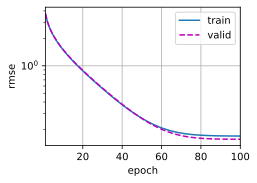

In [91]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64 # original 

train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold cross validation: average training log rmse: {float(train_l):f}, '
      f'average validation log rmse: {float(valid_l):f}')

**Tuning hyperparameters**

fold 1, train log rmse 0.133397, valid log rmse 0.142739
fold 2, train log rmse 0.127960, valid log rmse 0.153954
fold 3, train log rmse 0.128992, valid log rmse 0.154300
fold 4, train log rmse 0.133375, valid log rmse 0.132906
fold 5, train log rmse 0.124797, valid log rmse 0.159962
5-fold cross validation: average training log rmse: 0.129704, average validation log rmse: 0.148772


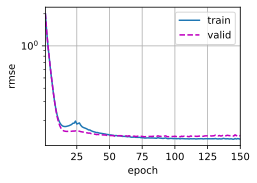

In [133]:
k, num_epochs, lr, weight_decay, batch_size = 5, 150, 15, 0.06, 32

train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold cross validation: average training log rmse: {float(train_l):f}, '
      f'average validation log rmse: {float(valid_l):f}')

train log rmse 0.130822


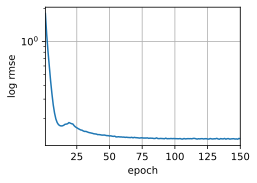

In [134]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy() ####
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0]) 
    # or
#     test_data['SalePrice'] = pd.Series(preds.flatten()) # or, preds.flatten()
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)